# PROCESSAMENTO DIGITAL DE SINAIS (TI0119) 
## Projeto Design de Filtros IIR

Nesse ___notebook___ demonstro a implementação de um *Filtro Discreto de Butterworth* utilizando dois métodos de realização:

* Invariância do Impulso
* Transformação Bilinear

Com esses métodos, obtemos os parâmetros de um filtro analógico representado, no caso do Filtro de Butterworth, pela seguinte função de transferência:

$$
    H_c(s) = \frac{K}{\displaystyle\prod_{i=0}^{N-1} \left( s - \Omega_c e^{j\left( \frac{\pi(1+2k+N)}{2N} \right)} \right)}
$$

onde $K = \lim_{s \to 0} \texttt{den}(H_c(s))$, e os parâmetros $\Omega_c$ e $N$ são, respectivamente, a **frequência de corte** e a **ordem** do filtro. O filtro digital $H(z)$ é obtida através dessa função de transferência de acordo com o método escolhido para realização do filtro.

**Obs.:** O filtro foi implementado na forma de uma classe, que recebe os parâmetros do filtro e o método de realização como parâmetros do construtor padrão.

### Bibliotecas

In [1]:
import numpy as np                   # Manipulações Numéricas e Matriciais
import matplotlib.pyplot as plt      # Visualizações das Funções

### Definição da Classe

In [2]:
## CLASSE: ButterworthFilter
# Cria um objeto representando um Filtro de Butterworth, provendo a função de transferência analógica e discreta
class ButterworthFilter(object):
    
    # __INIT__(w_p, w_s, delta_p1, delta_p2, delta_s, method) 
    #   Construtor de um objeto da classe Butterworth Filter
    #     w_p         Frequência máxima na banda de passagem
    #     w_s         Frequência mínima na banda de rejeição
    #     delta_p1    Variação superior máxima aceitável sobre a magnitude unitária na banda de passagem
    #     delta_p2    Variação inferior máxima aceitável sobre a magnitude unitária na banda de passagem
    #     delta_s     Limite superior máximo sobre a magnitude na banda de rejeição
    #     method      Método a ser utilizado na realização do filtro ("invariant"|"bilinear")
    def __init__(self, w_p, w_s, delta_p1, delta_p2, delta_s, method="invariant"):
        # Atribuições das Variáveis
        self.w_p = w_p
        self.w_s = w_s
        self.delta_p1 = delta_p1
        self.delta_p2 = delta_p2
        self.delta_s = delta_s
        
        # Cálculo dos Parâmetros do Filtro Analógico dado o Método selecionado
        self.N = np.ceil(self.getN(method)).astype(int)
        self.Omega_c = self.getOmega_c(method)

        # Realização do Filtro Analógico
        self.poles = self.getPoles()
        
        self.K = np.prod(-self.poles)
        self.H_c = lambda s : self.K / np.prod(s - self.poles)
        
        # Realização do Filtro Digital
        if (method == "invariant"):
            self.A = self.getA()
            self.H   = lambda z : np.sum(self.A / (1 - np.exp(self.poles) * z**(-1) ))
            
        elif (method == "bilinear"):
            self.H   = lambda z : self.H_c(2 * (1 - z**(-1)) / (1 + z**(-1)))
    
    # GETN(method) 
    #   Calcula a Ordem do Filtro de Butterworth analógico
    #     method         Método de realização utilizado para os parâmetros do filtro
    def getN(self, method="invariant"):
        if (method == "invariant"):
            Omega_p, Omega_s = (self.w_p, self.w_s) 
        elif (method == "bilinear"): 
            Omega_p, Omega_s = (2*np.tan(self.w_p/2), 2*np.tan(self.w_s/2))
        
        return (1/2) * (np.log10(1/(1-self.delta_p2)**2 - 1) - np.log10(1/self.delta_s**2 - 1)) / (np.log10(Omega_p) - np.log10(Omega_s))
    
    # GETOMEGA_C(method) 
    #   Calcula a Frequência de Corte do Filtro de Butterworth analógico
    #     method         Método de realização utilizado para os parâmetros do filtro
    def getOmega_c(self, method="invariant"):
        if (method == "invariant"):
            Omega_p = self.w_p
            return Omega_p / 10**(1/(2*self.N) * np.log10(1/(1-self.delta_p2)**2 - 1))
        
        elif (method == "bilinear"): 
            Omega_s = 2*np.tan(self.w_s/2)
            return Omega_s / 10**(1/(2*self.N) * np.log10(1/(self.delta_s)**2 - 1))
    
    # GETPOLES() 
    #   Calcula os polos do Filtro de Butterworth analógico
    def getPoles(self):
        poles = []
        for i in range(0,self.N):
            aux = self.Omega_c * np.exp((np.pi*(1+2*i+self.N)/(2*self.N))*1j)
            poles.append(aux)
        return np.array(poles)
    
    # GETA() 
    #   Calcula os numeradores da expansão de fração parciais do Filtro de Butterworth analógico
    def getA(self):
        poles_tile = np.tile(self.poles, (self.N, 1))
        s_j = np.diagonal(poles_tile).copy().reshape(-1,1)
        
        np.fill_diagonal(poles_tile, np.nan)
        poles_tile = poles_tile[~np.isnan(poles_tile)].reshape(poles_tile.shape[0], poles_tile.shape[1] - 1)
        
        return self.K / np.prod(s_j - poles_tile, axis=1)
    
    # FREQS() 
    #   Calcula a resposta em frequência do filtro para um intervalo específico
    #     W          Vetor de frequências para serem calculadas
    #     filType    Tipo do filtro a ser utilizado no cálculo
    def freqs(self, W, filType="digital"):
        if(filType == "analog"):
            h = [self.H_c(w) for w in W]
        elif(filType == "digital"):
            h = [self.H(np.exp(1j*w)) for w in W]
        
        return (np.abs(h), np.angle(h))

### Realização dos Filtros e Visualização

Para a realização dos Filtros Digitais, utilizei as especificações dadas:

$$
\begin{cases}
0.99 \leq | H(e^{j\omega}) | \leq 1 & \text{se } \phantom{.4\pi}0 \leq |\omega| \leq 0.4\pi \\
\phantom{0.99 \leq\ }| H(e^{j\omega}) | \leq 0.001 & \text{se } 0.6\pi \leq |\omega| \leq \pi
\end{cases}
$$

In [3]:
# Criação dos Objetos
bt_flt1 = ButterworthFilter(0.4*np.pi, 0.6*np.pi, 0, 1-0.99, 0.001, "invariant")
bt_flt2 = ButterworthFilter(0.4*np.pi, 0.6*np.pi, 0, 1-0.99, 0.001, "bilinear")

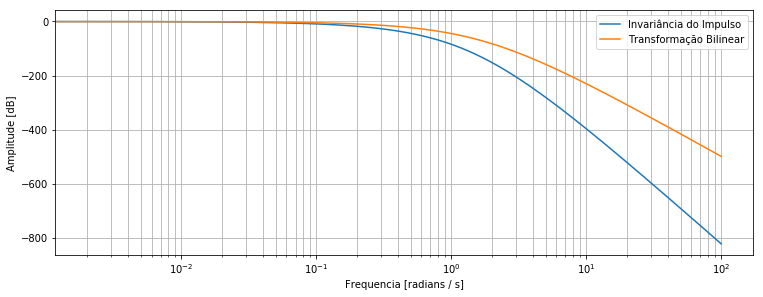

In [4]:
# Visualização dos Filtros - Analógica
W = np.linspace(0, 1e2, 50000)

mag1, _ = bt_flt1.freqs(W, "analog")
mag2, _ = bt_flt2.freqs(W, "analog")

plt.figure(figsize=(12.5,4.5))

plt.semilogx(W, 20*np.log10(mag1))
plt.semilogx(W, 20*np.log10(mag2))
plt.grid(which='both', axis='both')
plt.xlabel('Frequencia [radians / s]')
plt.ylabel('Amplitude [dB]')
plt.legend(['Invariância do Impulso', 'Transformação Bilinear'])

plt.show()
# plt.savefig("report/figs/analog.pdf")

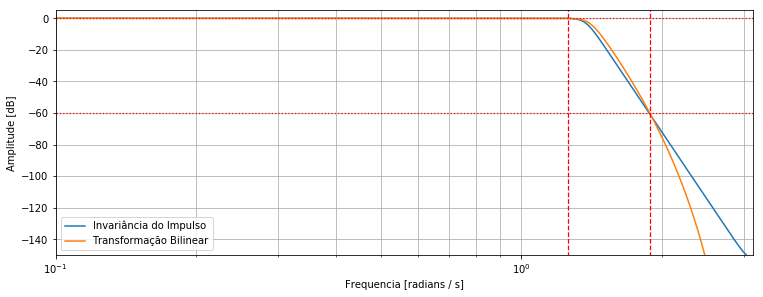

In [5]:
# Visualização do Filtro - Digital
W = np.linspace(0, np.pi, 50000)

mag1, _ = bt_flt1.freqs(W)
mag2, _ = bt_flt2.freqs(W)

plt.figure(figsize=(12.5,4.5))

plt.semilogx(W, 20*np.log10(mag1))
plt.semilogx(W, 20*np.log10(mag2))
plt.plot([bt_flt1.w_p, bt_flt1.w_p], [-155, 7], linewidth=1.25, color="red", linestyle='--')
plt.plot([bt_flt1.w_s, bt_flt1.w_s], [-155, 7], linewidth=1.25, color="red", linestyle='--')
plt.plot([1e-1, np.pi], [20*np.log10(1-bt_flt1.delta_p2), 20*np.log10(1-bt_flt1.delta_p2)], linewidth=1.25, color="red", linestyle=':')
plt.plot([1e-1, np.pi], [20*np.log10(bt_flt1.delta_s), 20*np.log10(bt_flt1.delta_s)], linewidth=1.25, color="red", linestyle=':')
plt.grid(which='both', axis='both')
plt.xlim([1e-1, np.pi]), plt.xlabel('Frequencia [radians / s]')
plt.ylim([-150, 5]), plt.ylabel('Amplitude [dB]')
plt.legend(['Invariância do Impulso', 'Transformação Bilinear'])

plt.show()
# plt.savefig("report/figs/digital.pdf")

----